# Exploring Y-variable for 3 arthritis severity classes and Shapley values

## imports

In [63]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import warnings
import re

from NHS_PROMs.load_data import load_proms, structure_name
from NHS_PROMs.preprocess import filter_in_range, filter_in_labels, method_delta
from NHS_PROMs.utils import downcast, map_labels
from NHS_PROMs.data_dictionary import meta_dict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import set_config
set_config(display='diagram')

import xgboost
import shap

pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

#from imblearn.over_sampling import SMOTENC

SEED = 888


## load data
General approach is not DRY for the sake of availability of having knee and hip df's always at hand, but also keep it readable (script-wise).

In [2]:
# load data + rename columns with structired name
# df_knee_raw = load_proms(part="knee").apply(downcast).rename(structure_name, axis=1)
df_hip_raw = load_proms(part="hip").apply(downcast).rename(structure_name, axis=1)

# get meta data for each
full_meta = {t + k: v for k, v in meta_dict.items() for t in ["t0_", "t1_"]}
hip_meta = {k: v for k, v in full_meta.items() if k in df_hip_raw.columns}

df_hip_raw.sample(3)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,...,t0_ohs_score,t1_ohs_pain,t1_ohs_sudden_pain,t1_ohs_night_pain,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score,t1_ohs_predicted
8126,NVC22,Hip Replacement,0,2019/20,70 to 79,2.0,2,0,9,2,2,1,9,9,9,...,16.0,1,2,2,3,2,2,2,3,1,2,2,2,24.0,39.44
13230,NXM01,Hip Replacement,0,2017/18,80 to 89,2.0,2,0,2,2,1,2,9,1,9,...,20.0,0,4,4,4,4,3,2,4,4,2,4,4,39.0,40.74
340,NT242,Hip Replacement,0,2018/19,None,NaN,2,0,2,2,1,2,9,9,9,...,26.0,4,4,4,4,4,4,4,4,4,4,4,4,48.0,44.49


## basic cleaning

In [3]:
endings = (
    "code",
    "procedure",
    "revision_flag",
    "assisted_by",
    "profile",
    "predicted",
)
cols2drop = [c for c in df_hip_raw.columns if c.endswith(endings)]

In [4]:
%%time
df_hip_clean = (
    df_hip_raw.apply(lambda s: filter_in_range(s, **hip_meta[s.name]))
    .apply(lambda s: filter_in_labels(s, **hip_meta[s.name]))
    .apply(lambda s: map_labels(s, **hip_meta[s.name]))
    .query("t0_revision_flag == 'no revision'")
    .drop(columns=cols2drop)
    .reset_index(drop=True)
    #     .replace("missing", np.nan)
)
df_hip_clean.sample(3)

CPU times: user 530 ms, sys: 44.1 ms, total: 574 ms
Wall time: 579 ms


,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,t0_circulation,t0_lung_disease,t0_diabetes,t0_kidney_disease,...,t0_ohs_work,t0_ohs_score,t1_ohs_pain,t1_ohs_sudden_pain,t1_ohs_night_pain,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
45579,April 2017 - April 2018,60 to 69,male,no,more than 10 years,no,with partner / spouse / family / friends,no,missing,yes,missing,missing,missing,missing,missing,...,most of the time,12.0,sometimes or just at first,rarely/never,"often, not just at first",rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,sometimes or just at first,rarely/never,sometimes or just at first,rarely/never,43.0
9783,April 2016 - April 2017,60 to 69,female,no,1 to 5 years,no,with partner / spouse / family / friends,no,missing,yes,missing,missing,missing,missing,missing,...,most of the time,8.0,"often, not just at first",rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,"often, not just at first",rarely/never,rarely/never,rarely/never,sometimes or just at first,"often, not just at first",sometimes or just at first,38.0
47705,April 2017 - April 2018,70 to 79,female,no,1 to 5 years,no,alone,yes,missing,missing,missing,missing,missing,missing,missing,...,"often, not just at first",24.0,"often, not just at first",rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,46.0


## split data

In [5]:
# split train + test set
# df_knee_seen = df_knee_clean.query("t0_year != '2019/20'")
# df_knee_unseen = df_knee_clean.query("t0_year == '2019/20'")

df_hip = df_hip_clean.query("t0_year != '2019/20'")
df_hip_unseen = df_hip_clean.query("t0_year == '2019/20'")

df_hip.sample(3)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,t0_circulation,t0_lung_disease,t0_diabetes,t0_kidney_disease,...,t0_ohs_work,t0_ohs_score,t1_ohs_pain,t1_ohs_sudden_pain,t1_ohs_night_pain,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
104496,April 2018 - April 2019,60 to 69,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,missing,missing,missing,missing,missing,missing,missing,...,all of the time,10.0,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,48.0
136397,April 2019 - April 2020,80 to 89,male,no,1 to 5 years,no,with partner / spouse / family / friends,missing,missing,yes,missing,missing,missing,missing,missing,...,most of the time,15.0,most of the time,all of the time,most of the time,most of the time,sometimes or just at first,sometimes or just at first,all of the time,most of the time,all of the time,"often, not just at first","often, not just at first",all of the time,14.0
45081,April 2017 - April 2018,70 to 79,female,no,6 to 10 years,no,alone,yes,missing,yes,missing,missing,missing,missing,missing,...,"often, not just at first",24.0,rarely/never,rarely/never,all of the time,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,44.0


In [6]:
#df_hip.info()

## create delta dataframes

In [7]:
# df_org = df_hip_seen.apply(
#     lambda s: map_labels(s, backwards=True, **hip_meta[s.name])
# ).apply(np.asarray)

# # df_knee_delta = method_delta(df_knee_train)
# df_hip_delta = method_delta(df_org)

# # now you could join them again with the original df ...
# # eg: df_hip_train.join(df_hip_delta)
# df_hip_delta.sample(5)

## Make feature set

In [8]:
print(len(df_hip), "original")
print(len(df_hip.dropna()), "after possible total dropna")
(df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

139251 original
103346 after possible total dropna


t0_age_band          0.09
t0_gender            0.09
t0_eqvas_score       0.09
t0_eq5d_score        0.06
t1_eqvas_score       0.05
t1_eq5d_score        0.04
t0_ohs_score         0.01
t1_ohs_score         0.01
t0_eq5d_mobility     0.00
t0_eq5d_self_care    0.00
dtype: float64

In [9]:
# remove NaNs from non categorical/ordinal columns (numerical)
print(len(df_hip), "original")
num_cols = df_hip.select_dtypes(exclude="category").columns
df_hip = df_hip.dropna(subset=num_cols)

print(len(df_hip), "after dropna on numerical")
(df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10)

139251 original
113818 after dropna on numerical


t0_age_band           0.09
t0_gender             0.09
t1_ohs_score          0.00
t1_assisted           0.00
t0_eq5d_mobility      0.00
t0_eq5d_self_care     0.00
t0_eq5d_activity      0.00
t0_eq5d_discomfort    0.00
t0_eq5d_anxiety       0.00
t0_eq5d_score         0.00
dtype: float64

In [10]:
#df_hip.info()
df_hip.keys()

Index(['t0_year', 't0_age_band', 't0_gender', 't0_assisted', 't0_symptom_period',
       't0_previous_surgery', 't0_living_arrangements', 't0_disability', 't0_heart_disease',
       't0_high_bp', 't0_stroke', 't0_circulation', 't0_lung_disease', 't0_diabetes',
       't0_kidney_disease', 't0_nervous_system', 't0_liver_disease', 't0_cancer', 't0_depression',
       't0_arthritis', 't0_eq5d_mobility', 't0_eq5d_self_care', 't0_eq5d_activity',
       't0_eq5d_discomfort', 't0_eq5d_anxiety', 't0_eq5d_score', 't1_assisted',
       't1_living_arrangements', 't1_disability', 't1_eq5d_mobility', 't1_eq5d_self_care',
       't1_eq5d_activity', 't1_eq5d_discomfort', 't1_eq5d_anxiety', 't1_satisfaction',
       't1_success', 't1_allergy', 't1_bleeding', 't1_wound', 't1_urine', 't1_further_surgery',
       't1_readmitted', 't1_eq5d_score', 't0_eqvas_score', 't1_eqvas_score', 't0_ohs_pain',
       't0_ohs_sudden_pain', 't0_ohs_night_pain', 't0_ohs_washing', 't0_ohs_transport',
       't0_ohs_dressin

### Construct y variable with arthritis severity categories

Based on the Q-scores, patients can be classified in 4 arthritis severity classes: 

0 - 19 = severe arthritis

20 - 29 = moderate arthritis

30 - 39 = mild-to-moderate arthritis

40 - 48 = satisfactory joint function

In [11]:
df_hip["arthritis_cat_t0"] = pd.cut(df_hip.t0_ohs_score,
                                     bins=[0,19,29,39,48],
       labels=['severe','moderate','mild','satisfactory'])

df_hip["arthritis_3cat_t0"] = pd.cut(df_hip.t0_ohs_score,
                                     bins=[0,19,29,48],
       labels=['severe','moderate','mild-satisfactory'])

In [12]:
(df_hip.arthritis_cat_t0.value_counts() / len(df_hip.arthritis_cat_t0)*100)

severe          60.49
moderate        30.84
mild             8.11
satisfactory     0.49
Name: arthritis_cat_t0, dtype: float64

In [13]:
(df_hip.arthritis_3cat_t0.value_counts() / len(df_hip.arthritis_3cat_t0)*100)

severe               60.49
moderate             30.84
mild-satisfactory     8.60
Name: arthritis_3cat_t0, dtype: float64

In [14]:
df_hip["arthritis_cat_t1"] = pd.cut(df_hip.t1_ohs_score,
                                     bins=[0,19,29,39,48],
       labels=['severe','moderate','mild','satisfactory'])

In [15]:
(df_hip.arthritis_cat_t1.value_counts() / len(df_hip.arthritis_cat_t1)*100)

satisfactory    65.89
mild            22.46
moderate         8.45
severe           3.20
Name: arthritis_cat_t1, dtype: float64

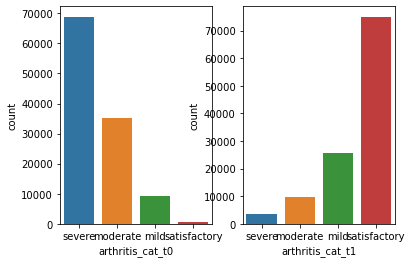

In [16]:
fig, ax = plt.subplots(1, 2)
sns.countplot(x=df_hip.arthritis_cat_t0, ax=ax[0])
sns.countplot(x=df_hip.arthritis_cat_t1, ax=ax[1])
plt.show()

In [17]:
table = pd.crosstab(df_hip["arthritis_cat_t0"], df_hip["arthritis_cat_t1"])
table

arthritis_cat_t1,severe,moderate,mild,satisfactory
arthritis_cat_t0,,,,
severe,3144,7649,17689,40359
moderate,427,1695,6588,26394
mild,48,246,1212,7728
satisfactory,3,10,45,499


### Severity categories imbalanced

At t0 there are, as expected, few patients in the "satisfactory" and the "mild" categories. After operation, the pattern reverses, most patients are in the "satisfactory" and "mild" category and a small number of few remain in the "severe" and "moderate" category.

To avoid an extremely imbalanced Y-variable, we combine the categories "severe" and "mild" at t1 into one category.

In [18]:
df_hip["arthritis_3cat_t1"] = pd.cut(df_hip.t1_ohs_score,
                                     bins=[0,29,39,48],
       labels=['severe-moderate','mild','satisfactory'])

In [19]:
(df_hip.arthritis_3cat_t1.value_counts() / len(df_hip.arthritis_3cat_t1)*100)

satisfactory       65.89
mild               22.46
severe-moderate    11.65
Name: arthritis_3cat_t1, dtype: float64

In [20]:
df_hip = df_hip.dropna().sample(10_000) # dirty drop for the sake of testing pl
#df_hip.info()

In [21]:
# select variables for predictor matrix
X0_cols = ['t0_eq5d_score', 't0_ohs_score', 't0_eqvas_score', 't0_age_band','t0_gender', 
           't0_assisted','t0_symptom_period', 't0_previous_surgery', 't0_living_arrangements',
           't0_disability', 't0_heart_disease', 't0_high_bp', 't0_stroke',
           't0_circulation', 't0_lung_disease', 't0_diabetes', 't0_kidney_disease',
           't0_nervous_system', 't0_liver_disease', 't0_cancer', 't0_depression']


X_cols =['t0_eqvas_score', 't0_age_band', 't0_gender', 't0_assisted',
       't0_symptom_period', 't0_previous_surgery', 't0_living_arrangements',
       't0_disability', 't0_heart_disease', 't0_high_bp', 't0_stroke',
       't0_circulation', 't0_lung_disease', 't0_diabetes', 't0_kidney_disease',
       't0_nervous_system', 't0_liver_disease', 't0_cancer', 't0_depression',
       't0_eq5d_mobility', 't0_eq5d_self_care',
       't0_eq5d_activity', 't0_eq5d_discomfort', 't0_eq5d_anxiety',
       't0_ohs_pain','t0_ohs_sudden_pain', 't0_ohs_night_pain', 
       't0_ohs_washing','t0_ohs_transport', 't0_ohs_dressing', 
       't0_ohs_shopping', 't0_ohs_walking', 't0_ohs_limping', 
       't0_ohs_stairs', 't0_ohs_standing','t0_ohs_work']


In [22]:
#from sklearn.preprocessing import StandardScaler
#from sklearn import preprocessing

#X0 = df_hip[X0_cols]

# define y variable: arthritis in 3 categories: 
#satisfactory, mild, severe-moderate
#y = df_hip["arthritis_3cat_t1"]

# scale the continuous variables
#numeric_columns = list(X0.select_dtypes(exclude = 'category'))
#print(numeric_columns)
#categorical_columns = list(X0.select_dtypes(include = 'category'))
#print(categorical_columns)

#X0_scaled = preprocessing.scale(X0[numeric_columns])
#df_scaled = pd.DataFrame(X0_scaled, columns=X0[numeric_columns].columns)
#df_cat = pd.DataFrame(X0[categorical_columns], columns=X0[categorical_columns].columns)
# get dummies for all categorical variables
#X = pd.get_dummies(X0, prefix_sep='_', drop_first=False)

#X0_s = pd.concat([df_scaled, df_cat], axis=1)
#X0_s.info()


In [140]:
y_cont = df_hip["t1_ohs_score"]

X0 = df_hip[X0_cols]
X = df_hip[X_cols]

y = df_hip["arthritis_3cat_t1"]
#X0 = pd.get_dummies(X0, prefix_sep='_', drop_first=False)
X0 = pd.get_dummies(X0, prefix_sep='_', drop_first=True)
#X = pd.get_dummies(X, prefix_sep='_', drop_first=False)
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

### Simple linear regression

y = continuous OHS scores at t1


X0 = 
t0_eq5d_score, t0_ohs_score, t0_eqvas_score, t0_age_band, t0_gender, 
t0_assisted, t0_symptom_period, t0_previous_surgery, t0_living_arrangements, t0_disability, t0_heart_disease, t0_high_bp, t0_stroke,
t0_circulation, t0_lung_disease, t0_diabetes, t0_kidney_disease,
t0_nervous_system, t0_liver_disease, t0_cancer, t0_depression

In [141]:
from sklearn.linear_model import LinearRegression

linregmodel = LinearRegression().fit(X0, y_cont)
r_sq = linregmodel.score(X0, y_cont)
print('coefficient of determination:', r_sq)


coefficient of determination: 0.1651427319189852


In [25]:
#X0.info()

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 102488 to 41679
Columns: 146 entries, t0_eqvas_score to t0_ohs_work_missing
dtypes: float64(1), uint8(145)
memory usage: 1.5 MB


In [142]:
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0, y, test_size=0.30, random_state=SEED, stratify=y)

In [143]:
print("The distribution of Outcome in the training set is: \n", y0_train.value_counts(normalize=True))

print("The distribution of Outcome in the test set is: \n", y0_test.value_counts(normalize=True))

The distribution of Outcome in the training set is: 
 satisfactory       0.65
mild               0.23
severe-moderate    0.12
Name: arthritis_3cat_t1, dtype: float64
The distribution of Outcome in the test set is: 
 satisfactory       0.65
mild               0.23
severe-moderate    0.12
Name: arthritis_3cat_t1, dtype: float64


In [144]:
# create x, y
#X = df_hip.filter(regex="t0")
#y = (df_hip["t1_ohs_score"] - df_hip["t0_ohs_score"] <= 8).astype(int) # knee <= 7
#y = df_hip["t1_ohs_score"]

# create train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y)

In [145]:
print("The distribution of Outcome in the training set is: \n", y_train.value_counts(normalize=True))

print("The distribution of Outcome in the test set is: \n", y_test.value_counts(normalize=True))

The distribution of Outcome in the training set is: 
 satisfactory       0.65
mild               0.23
severe-moderate    0.12
Name: arthritis_3cat_t1, dtype: float64
The distribution of Outcome in the test set is: 
 satisfactory       0.65
mild               0.23
severe-moderate    0.12
Name: arthritis_3cat_t1, dtype: float64


In [146]:
observationX0_35 = X0_test.iloc[35, :]
print(observationX0_35)

t0_eq5d_score                -0.02
t0_ohs_score                 15.00
t0_eqvas_score               60.00
t0_age_band_30 to 39          0.00
t0_age_band_40 to 49          0.00
                             ...  
t0_kidney_disease_missing     1.00
t0_nervous_system_missing     1.00
t0_liver_disease_missing      1.00
t0_cancer_missing             1.00
t0_depression_missing         1.00
Name: 63744, Length: 38, dtype: float64


In [147]:
classY0_35 = y0_test.iloc[35]
print(classY_35)

mild


In [148]:
observationX35 = X_test.iloc[35, :]
print(observationX35)

t0_eqvas_score                            60.0
t0_age_band_30 to 39                       0.0
t0_age_band_40 to 49                       0.0
t0_age_band_50 to 59                       0.0
t0_age_band_60 to 69                       0.0
                                          ... 
t0_ohs_work_most of the time               1.0
t0_ohs_work_often, not just at first       0.0
t0_ohs_work_sometimes or just at first     0.0
t0_ohs_work_rarely/never                   0.0
t0_ohs_work_missing                        0.0
Name: 63744, Length: 111, dtype: float64


In [149]:
classY35 = y_test.iloc[35]
print(classY35)

mild


### Simple multi class logistic regression

In [150]:
logreg_0model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=10000, random_state=SEED)
logreg_0model.fit(X0_train, y0_train)

LogisticRegression(max_iter=10000, multi_class='ovr', random_state=888)

In [204]:
# True class for patient 35
print('True arthritis class: %s' % y_test.iloc[35])
# predict probabilities for classes in X_test
yhat0 = logreg_0model.predict(X0_test)
# predict a multinomial probability distribution
yhatc0 = logreg_0model.predict([X0_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc0)
yhat0_class = logreg_0model.predict_proba([X0_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities for resp. mild, satisfactory, severe-moderate: %s' % yhat0_class[0])

True arthritis class: mild
Predicted Arthritis class: ['satisfactory']
Predicted Probabilities for resp. mild, satisfactory, severe-moderate: [0.2874733  0.62795109 0.08457561]


In [152]:
print(classification_report(y0_test, yhat0))

                 precision    recall  f1-score   support

           mild       0.43      0.05      0.09       681
   satisfactory       0.68      0.97      0.80      1961
severe-moderate       0.39      0.13      0.20       358

       accuracy                           0.66      3000
      macro avg       0.50      0.38      0.36      3000
   weighted avg       0.59      0.66      0.57      3000



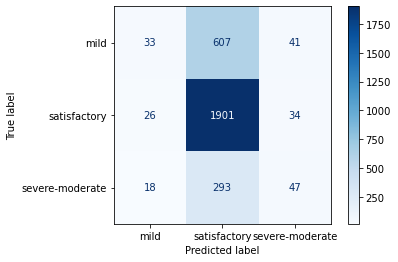

In [153]:
plot_confusion_matrix(logreg_0model, X0_test, y0_test, cmap=plt.cm.Blues) 
plt.show()

### Multi class logistic regression with balanced class weights

In [154]:
logregW_0model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=10000, 
                                   class_weight='balanced', random_state=SEED)
# multi_class = 'ovr' 'multinomial'
logregW_0model.fit(X0_train, y0_train)

LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr',
                   random_state=888)

In [205]:
# True class for patient 35
print('True arthritis class: %s' % y_test.iloc[35])
# predict probabilities for classes in X_test
yhatW = logregW_0model.predict(X0_test)
yhatc = logregW_0model.predict([X0_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
# predict a multinomial probability distribution
yhatW_class = logregW_0model.predict_proba([X0_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities for resp. mild, satisfactory, severe-moderate: %s' % yhatW_class[0])

True arthritis class: mild
Predicted Arthritis class: ['mild']
Predicted Probabilities for resp. mild, satisfactory, severe-moderate: [0.4010824  0.31238185 0.28653574]


In [156]:
print(classification_report(y0_test, yhatW))

                 precision    recall  f1-score   support

           mild       0.32      0.27      0.30       681
   satisfactory       0.79      0.64      0.71      1961
severe-moderate       0.25      0.56      0.34       358

       accuracy                           0.55      3000
      macro avg       0.45      0.49      0.45      3000
   weighted avg       0.62      0.55      0.57      3000



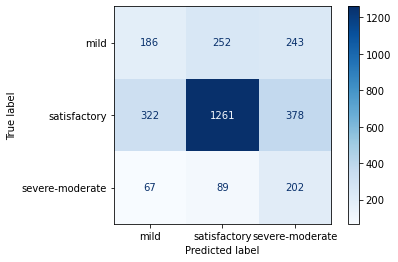

In [157]:
plot_confusion_matrix(logregW_0model, X0_test, y0_test, cmap=plt.cm.Blues) 
plt.show()

### Multiclass logistic regression model with the complete feature set

In [158]:
logreg_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=10000, random_state=SEED)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='ovr', random_state=888)

In [209]:
print('True arthritis class: %s' % y_test.iloc[35])
# predict probabilities for classes in X_test
yhat = logreg_model.predict(X_test)
# predict a multinomial probability distribution
yhatc = logreg_model.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
yhat_class = logreg_model.predict_proba([X_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities for resp. mild, satisfactory, severe-moderate: %s' % yhat_class[0])

True arthritis class: mild
Predicted Arthritis class: ['satisfactory']
Predicted Probabilities for resp. mild, satisfactory, severe-moderate: [0.3276784  0.53866904 0.13365256]


In [160]:
print(classification_report(y_test, yhat))

                 precision    recall  f1-score   support

           mild       0.44      0.07      0.11       681
   satisfactory       0.69      0.96      0.80      1961
severe-moderate       0.39      0.17      0.24       358

       accuracy                           0.66      3000
      macro avg       0.50      0.40      0.38      3000
   weighted avg       0.59      0.66      0.58      3000



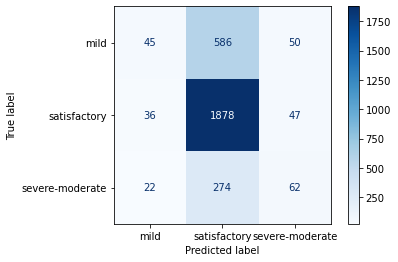

In [161]:
plot_confusion_matrix(logreg_model, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

### Multi class logistic regression with balanced weights

In [162]:
logregW_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=10000, 
                                   class_weight='balanced', random_state=SEED)
# multi_class = 'ovr' 'multinomial'
logregW_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr',
                   random_state=888)

In [210]:
print('True arthritis class: %s' % y_test.iloc[35])
# predict probabilities for classes in X_test
yhatW = logregW_model.predict(X_test)
yhatc = logregW_model.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
# predict a multinomial probability distribution
yhatW_class = logregW_model.predict_proba([X_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities for resp. mild, satisfactory, severe-moderate: %s' % yhatW_class[0])

True arthritis class: mild
Predicted Arthritis class: ['mild']
Predicted Probabilities for resp. mild, satisfactory, severe-moderate: [0.41028123 0.24108281 0.34863596]


In [164]:
print(classification_report(y_test, yhatW))

                 precision    recall  f1-score   support

           mild       0.30      0.28      0.29       681
   satisfactory       0.79      0.65      0.71      1961
severe-moderate       0.24      0.49      0.32       358

       accuracy                           0.55      3000
      macro avg       0.44      0.48      0.44      3000
   weighted avg       0.61      0.55      0.57      3000



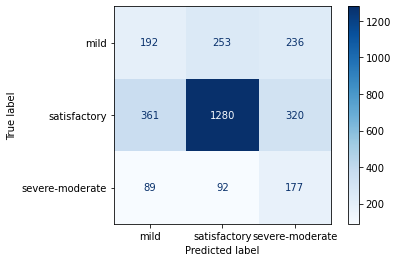

In [165]:
plot_confusion_matrix(logregW_model, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

### Multi class L1 regularized logistic regression

In [166]:
logregL1_model = LogisticRegression(multi_class='ovr', solver='saga', max_iter=10000, 
                                    penalty='l1', random_state=SEED)

logregL1_model.fit(X_train, y_train)


LogisticRegression(max_iter=10000, multi_class='ovr', penalty='l1',
                   random_state=888, solver='saga')

In [211]:
print('True arthritis class: %s' % y_test.iloc[35])
# predict probabilities for classes in X_test
yhatL1 = logregL1_model.predict(X_test)
yhatc = logregL1_model.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
# predict a multinomial probability distribution
yhatL1_class = logregL1_model.predict_proba([X_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities for resp. mild, satisfactory, severe-moderate: %s' % yhatL1_class[0])

True arthritis class: mild
Predicted Arthritis class: ['satisfactory']
Predicted Probabilities for resp. mild, satisfactory, severe-moderate: [0.32136043 0.54002196 0.13861761]


In [168]:
print(classification_report(y_test, yhatL1))

                 precision    recall  f1-score   support

           mild       0.45      0.06      0.11       681
   satisfactory       0.69      0.96      0.80      1961
severe-moderate       0.39      0.17      0.24       358

       accuracy                           0.66      3000
      macro avg       0.51      0.40      0.38      3000
   weighted avg       0.60      0.66      0.58      3000



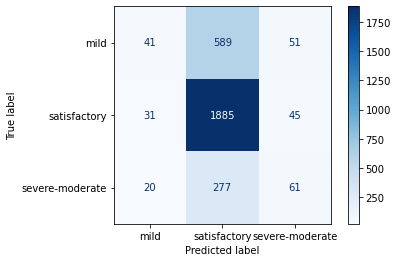

In [169]:
plot_confusion_matrix(logregL1_model, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

### Multi class L1 regularized logistic regression with balanced weights 

In [170]:
logregWL1_model = LogisticRegression(multi_class='ovr', solver='saga', max_iter=10000, 
                                     penalty='l1', class_weight='balanced', random_state=SEED)

logregWL1_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr',
                   penalty='l1', random_state=888, solver='saga')

In [212]:
print('True arthritis class: %s' % y_test.iloc[35])
# predict probabilities for classes in X_test
yhatWL1 = logregWL1_model.predict(X_test)
yhatc = logregWL1_model.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % yhatc)
# predict a multinomial probability distribution
yhatWL1_class = logregWL1_model.predict_proba([X_test.iloc[35, :]])
# summarize the predicted probabilities
print('Predicted Probabilities for resp. mild, satisfactory, severe-moderate: %s' % yhatWL1_class[0])

True arthritis class: mild
Predicted Arthritis class: ['mild']
Predicted Probabilities for resp. mild, satisfactory, severe-moderate: [0.40726173 0.24079335 0.35194492]


In [172]:
print(classification_report(y_test, yhatWL1))

                 precision    recall  f1-score   support

           mild       0.30      0.29      0.29       681
   satisfactory       0.79      0.65      0.71      1961
severe-moderate       0.24      0.50      0.33       358

       accuracy                           0.55      3000
      macro avg       0.44      0.48      0.44      3000
   weighted avg       0.61      0.55      0.57      3000



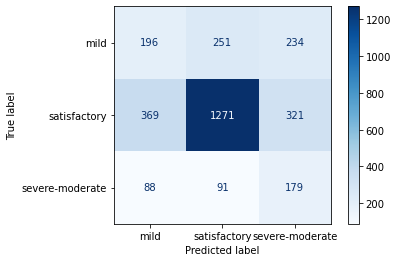

In [173]:
plot_confusion_matrix(logregWL1_model, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

## Simple random forest model

In [174]:
RFmodel = RandomForestClassifier(n_estimators=1000, min_samples_split=30, min_samples_leaf=15, class_weight="balanced") 
RFmodel_fit = RFmodel.fit(X_train, y_train)

In [214]:
predictRF = RFmodel.predict(X_test)
print(classification_report(y_test, predictRF))

                 precision    recall  f1-score   support

           mild       0.29      0.23      0.26       681
   satisfactory       0.78      0.66      0.72      1961
severe-moderate       0.24      0.53      0.33       358

       accuracy                           0.55      3000
      macro avg       0.44      0.47      0.43      3000
   weighted avg       0.60      0.55      0.57      3000



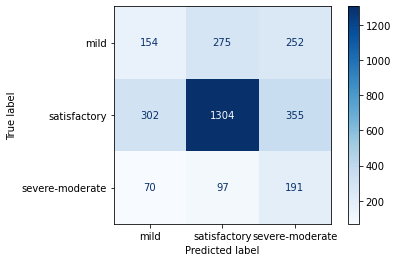

In [215]:
plot_confusion_matrix(RFmodel, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()

## Shapley values

In [177]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(RFmodel)

# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)



### Feature importance for each of the three classes in one plot
0=mild, 1=satisfactory, 2=severe-moderate

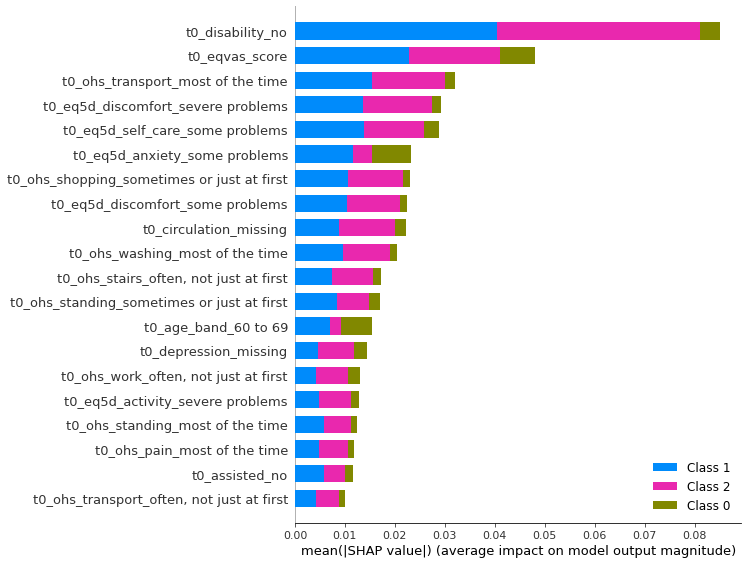

In [178]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Feature importance for class 0 = mild arthritis

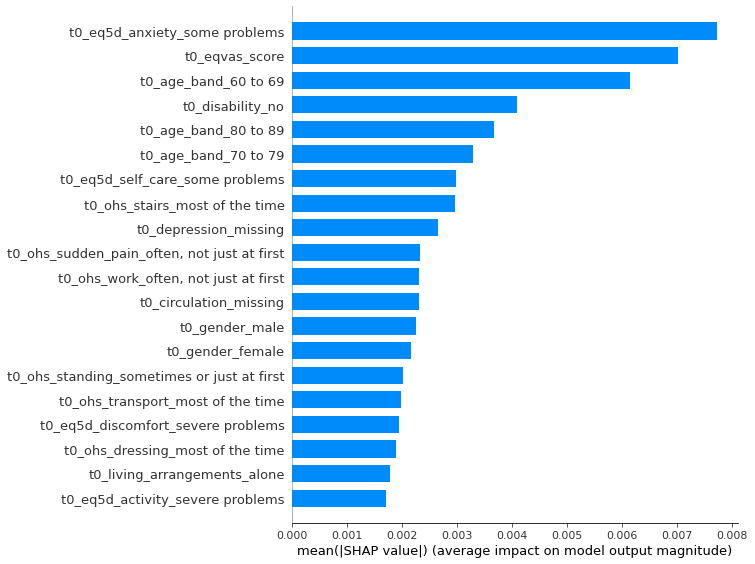

In [181]:
shap.summary_plot(shap_values[0], X_test, plot_type="bar")

### Feature importance for class 1 = satisfactory arthritis

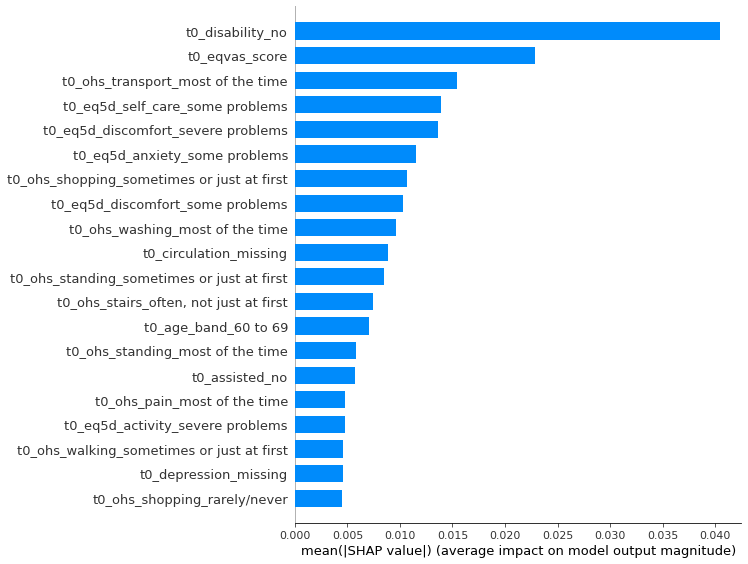

In [182]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

### Feature importance for class 2 = severe-moderate

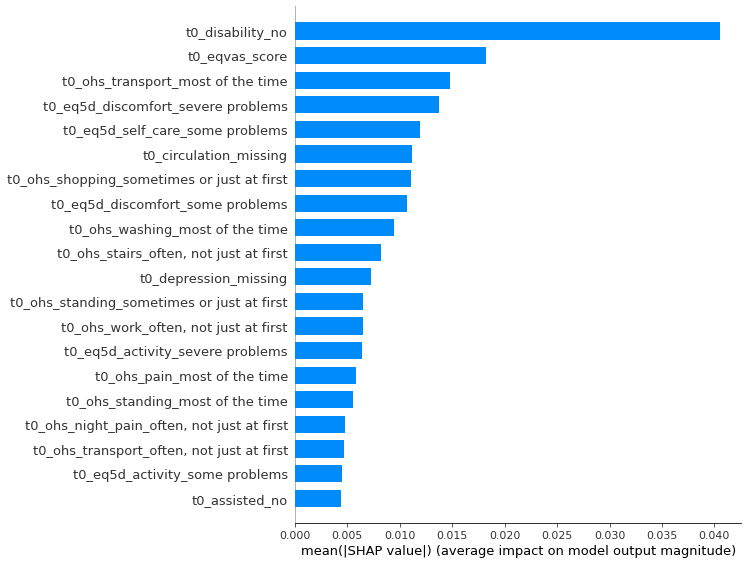

In [183]:
shap.summary_plot(shap_values[2], X_test, plot_type="bar")

### Try to predict shapley values for one patient 35 (true class = mild)

First the predicted probabilities for each class for patient nr 35. 


In [184]:
print('True arthritis class: %s' % y_test.iloc[35])
predict_35_class = RFmodel.predict([X_test.iloc[35, :]])
print('Predicted Arthritis class: %s' % predict_35_class)
# predict a multinomial probability distribution
predict_35_probs = RFmodel.predict_proba([X_test.iloc[35, :]])
print('Predicted Probabilities for resp. mild, satisfactory, severe-moderate: %s' % predict_35_probs[0])

True arthritis class: mild
Predicted Arthritis class: ['mild']
Predicted Probabilities for resp. mild, satisfactory, severe-moderate: [0.37874523 0.31560215 0.30565262]


## Shapley values for patient 35 (true class = mild)

### Shapley values for patient 10 for predicted class "mild"
Patient 35 has a predicted score "mild" arthritis (class = 0). Predicted score for the mild class = 0.38.
Most important features that lead to the prediction of the class mild for this patient are: t0_eqvas_score = 60, anxiety item on EQ5D = some problems, often problems with climbing stairs and often problems with using public transportation. 

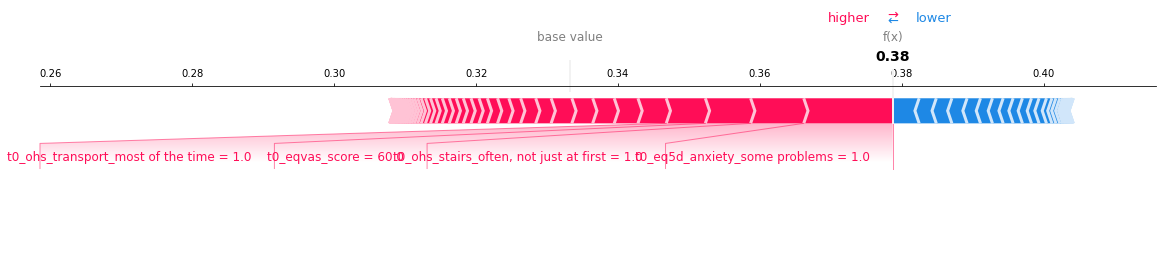

In [186]:
shap.force_plot(explainer.expected_value[0], shap_values[0][35,:], X_test.iloc[35,:], matplotlib=True)

### Shapley values for patient 10 for predicted class "satisfactory"
Patient 35 has a predicted probability equal to 0.33 to be classified in the "satisfactory" class. Preoperative factors that increase the probability for this patient to be classified in this class are: no disability, often not being able to climb stairs. Factors that decrease the probability for this patient to be classified as "satisfactory" are: some problems with anxiety and not being able most of time to use public transportation.

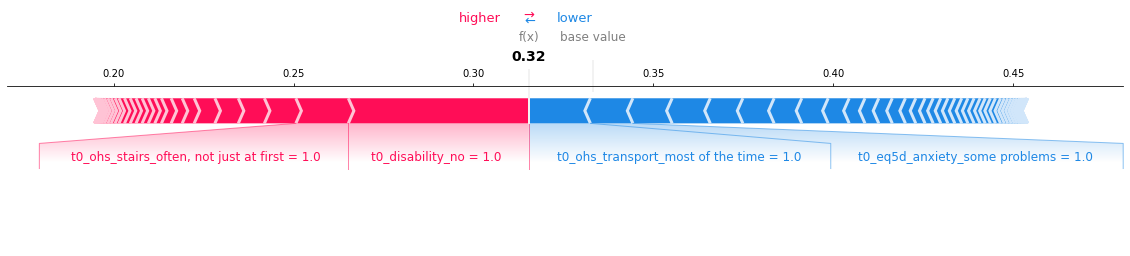

In [187]:
shap.force_plot(explainer.expected_value[0], shap_values[1][35,:], X_test.iloc[35,:], matplotlib=True)

### Shapley values for patient 10 for predicted class "moderate-severe"

Patient 35 has a predicted probability equal to 0.31 to be in the class "moderate-severe". Pre-operative factors that increase the probability that this patient might be classified in the moderate-servere class is having severe problems with discomfort and not being able to use public transportation most of the time. 

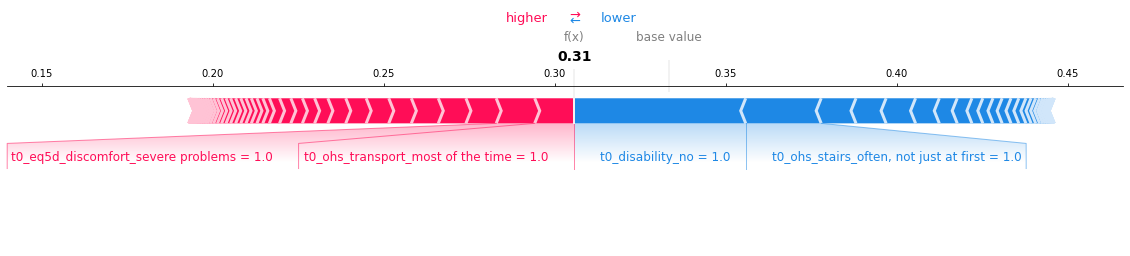

In [189]:
shap.force_plot(explainer.expected_value[0], shap_values[2][35,:], X_test.iloc[35,:], matplotlib=True)

### Shapley values for one patient 10 (true class = satisfactory)

First the predicted class for this patient and the predicted probabilities for each of the three arthritis severity classes

In [190]:
print('True arthritis class: %s' % y_test.iloc[10])
predict_10_class = RFmodel.predict([X_test.iloc[10, :]])
print('Predicted Arthritis class: %s' % predict_10_class)
# predict a multinomial probability distribution
predict_10_probs = RFmodel.predict_proba([X_test.iloc[10, :]])
print('Predicted Probabilitie for resp. mild, satisfactory, severe-moderate: %s' % predict_10_probs[0])

True arthritis class: satisfactory
Predicted Arthritis class: ['satisfactory']
Predicted Probabilitie for resp. mild, satisfactory, severe-moderate: [0.2883936  0.51192283 0.19968357]


### Shapley values for patient 10 for predicted class "mild"

Patient 10 has a probability of 0.29 to be classified in the mild arthritis class. Preoperative factors that increase the probability to be classified as "mild" for this patient are: some problems with self care. 
Pre-operative factors that lower the probability of being classified as mild are: EQVAS score = 90, no disability and anxiety some problems = 0 (? not clear from the plot). 

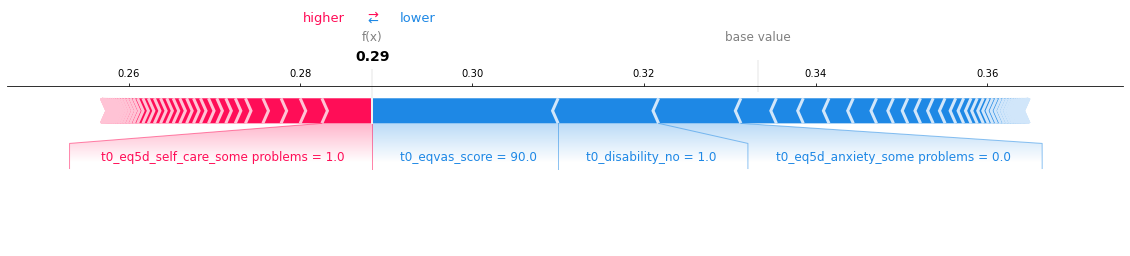

In [202]:
shap.force_plot(explainer.expected_value[0], shap_values[0][10,:], X_test.iloc[10,:], matplotlib=True)

### Shapley values for patient 10 for  predicted class "satisfactory"

Patient 10 has a probability of 0.51 to be classified in the class "satisfactory" after the operation. Preoperative factors that increase the probability to be classified as satisfactory for this patient are: no problems with using public transportation, no disability, EQVAS score = 90. Possible factor that lowers the probability of being in the satisfactory class is that for this patient information about lung disease is missing. 

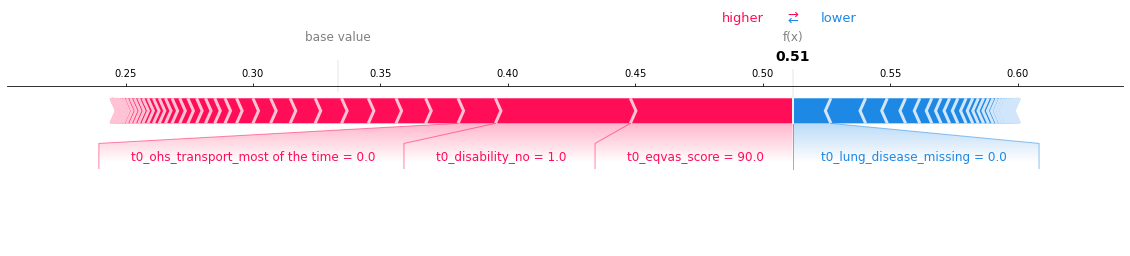

In [203]:
shap.force_plot(explainer.expected_value[0], shap_values[1][10,:], X_test.iloc[10,:], matplotlib=True)

### Shapley values for patient 10 for predicted class "moderate-severe"

Patient 10 has a probability of .20 to be classified in the class moderate to severe after the operation. Preoperative factors that increase this probability are: information about lung disease is missing. 
Preoperative factors that decrease the probability for this patient to end up in the moderate-severe class are: EQVAS score = 90, no disability and no severe discomfort problems. 

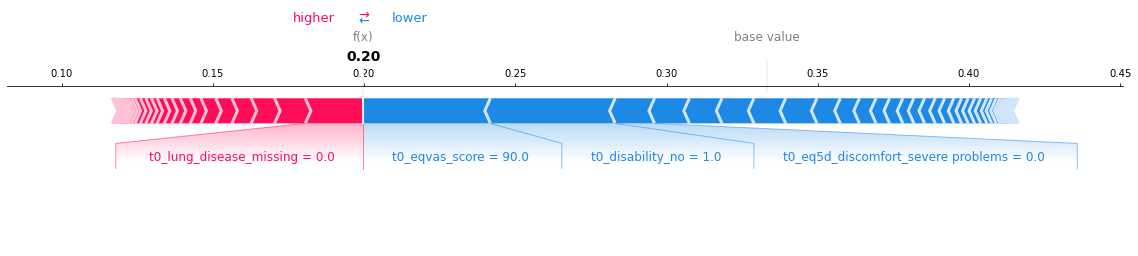

In [196]:
shap.force_plot(explainer.expected_value[0], shap_values[2][10,:], X_test.iloc[10,:], matplotlib=True)

## Distribution plots of shapley values

### Results Random forest for class 0 = mild

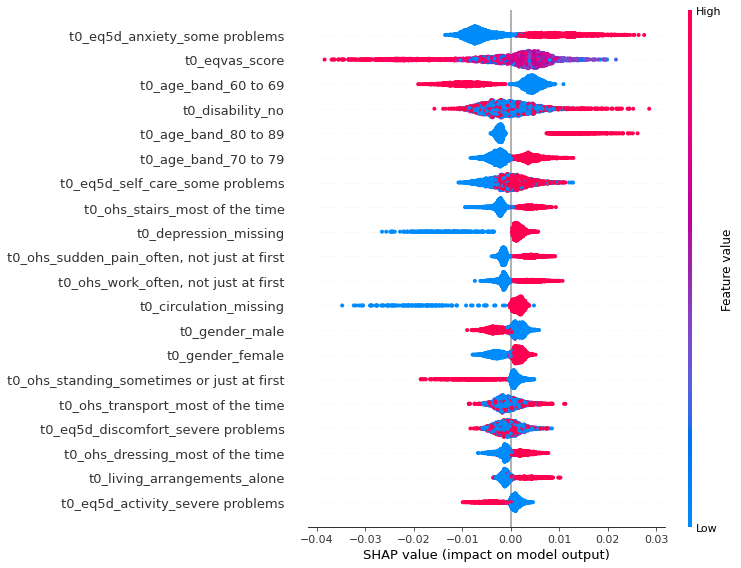

In [197]:
shap.summary_plot(shap_values[0], X_test)

### Results Random forest for class 1 = satisfactory

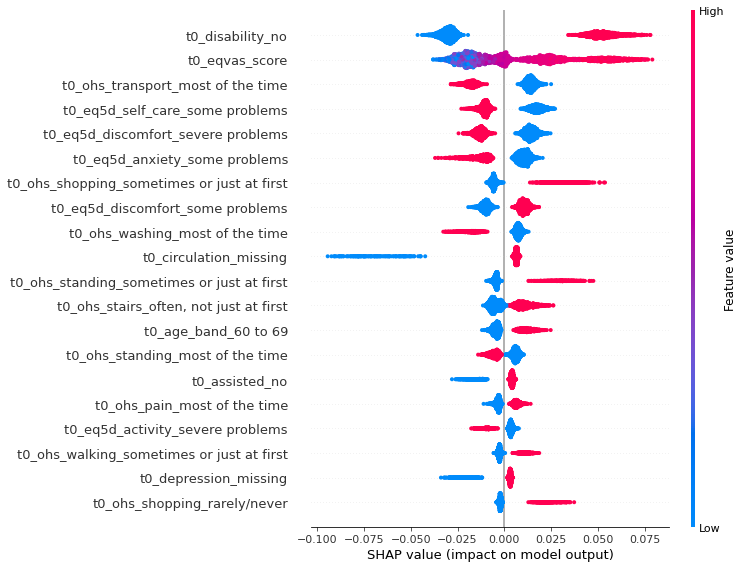

In [198]:
shap.summary_plot(shap_values[1], X_test)

### Results Random forest for class 2 = severe-moderate

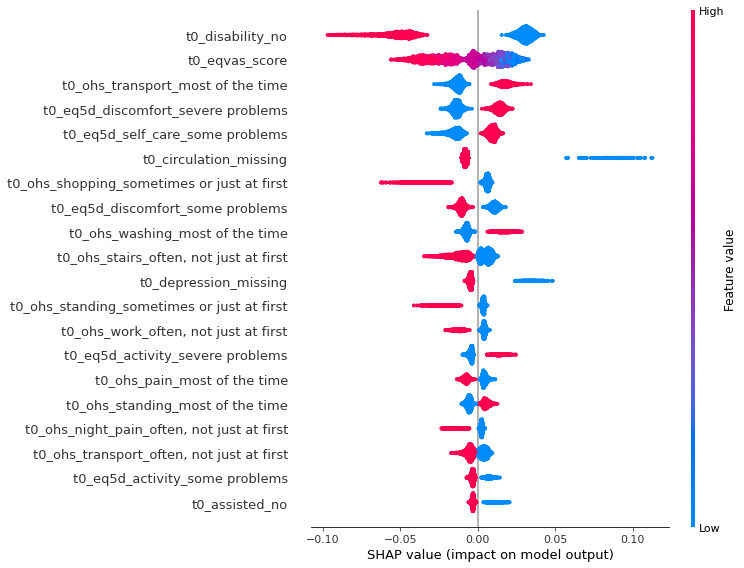

In [199]:
shap.summary_plot(shap_values[2], X_test)

### Shapley values for specific variables

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


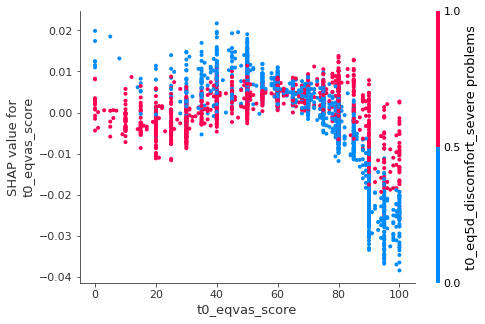

In [200]:
shap.dependence_plot("t0_eqvas_score", shap_values[0], X_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


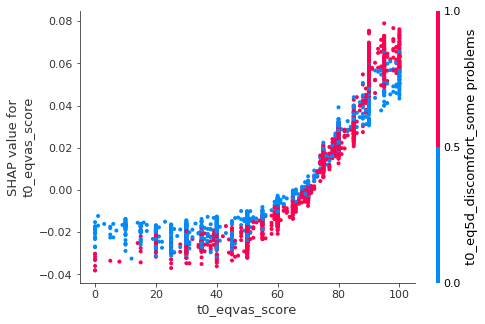

In [201]:
shap.dependence_plot("t0_eqvas_score", shap_values[1], X_test)